In [1]:
###############################################################################
#                          Libraries to use
###############################################################################

#########
#########
#########  Pyswarm package is from 2014.  Convert over to pyswarms, which has 
#########  active development.  This may help to improve convergence issues.
#########
#########


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import csv

#!pip install pyswarm
#!pip install lmfit
from pyswarm import pso
from lmfit import (Minimizer, minimize, Parameters, Parameter, report_fit, 
                   fit_report)
from scipy.integrate import odeint
from scipy import interpolate

In [3]:
## Note that pandas automatically outputs a dataframe a la R,
## only no slicing indexing allowed.  To do that, you must coerce
## to an array.

#data_url = 'https://raw.githubusercontent.com/alexbbrummer/car_T/master/cart_dex_mean_sd_gbm_single_line.csv'
data_url = "../data/pbt_second_round/car_T_dex_pbt1_pbt2_lines.csv"
data = pd.read_csv(data_url)

In [4]:
## Examine first five rows of data

data.head()

,Time (Hour),"Y(A1,A2)","SD(A1,A2)","Y(B1,B2)","SD(B1,B2)","Y(C1,C2)","SD(C1,C2)","Y(D1,D2)","SD(D1,D2)","Y(E1,E2)",...,"Y(D11,D12)","SD(D11,D12)","Y(E11,E12)","SD(E11,E12)","Y(F11,F12)","SD(F11,F12)","Y(G11,G12)","SD(G11,G12)","Y(H11,H12)","SD(H11,H12)"
0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
1,0.004722,-0.00390,0.000566,-0.00040,0.001838,0.00015,0.000495,-0.00220,0.000707,0.00120,...,-0.00110,0.000849,0.00030,0.000424,-0.00105,0.000354,-0.00060,0.000424,-0.00035,0.001626
2,0.254722,-0.06250,0.001838,-0.03030,0.001980,-0.02180,0.004243,-0.01415,0.007000,-0.00995,...,-0.01040,0.003960,-0.00495,0.001344,-0.01575,0.006152,-0.02505,0.002051,-0.01740,0.006223
3,1.289444,0.09315,0.016476,0.10135,0.003889,0.07870,0.014142,0.06665,0.000636,0.12915,...,0.09630,0.005091,0.14485,0.000919,0.14610,0.010182,0.15320,0.004808,0.22425,0.005303
4,1.539722,0.01890,0.005798,0.06200,0.002687,0.06095,0.010960,0.06450,0.000990,0.23370,...,0.07995,0.006010,0.23830,0.004101,0.23150,0.010324,0.22515,0.007990,0.32560,0.015556


In [5]:
###############################################################################
#                     ODE system Model writing
#       currently hardcoded for modeling with/without dex, without t cells
#     uses try/except to toggle use with lmfit (the try) or pyswarm (the
#     exception) and logicals to toggle for with and without dex:
#     (1) gradient along dex without t cell
###############################################################################

def f_growth(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
      # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        # Different if/elif conditions are for calling back to this function
        # at different future uses.
        if len(ps) == 2:
            rho, kappainv = ps
            c0 = 0
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0
        elif len(ps) == 3:
            rho, kappainv, c0 = ps
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0
        elif len(ps) == 1:
            c0 = ps
            rho = result_growth.params['rho'].value
            kappainv = result_growth.params['kappainv'].value
            kappac1 = 0
            kappac2 = 0
            theta = 0
            c3 = 0

    x, y = xs
    
    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_growth(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_growth, x0, t, args=(ps, t_start))
    return x

def rms_growth(ps, *args):
    x0, ts, data, sigma = args
    model = g_growth(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    rms = np.sqrt(np.mean(res**2))
    return rms

def residual_growth(ps, *args):
    x0, ts, data, sigma = args
    model = g_growth(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    return ((model[:,0] - data)/sigma).ravel()

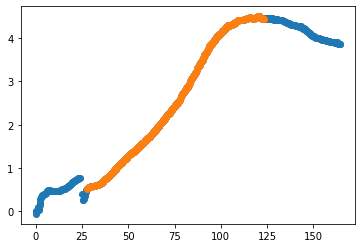

In [7]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#                     Define data to be used.
#     User must specify start, end, column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

start_0 = 105
end_0 = 487
#data_column_0 = 'Y(H1,H2)'
data_column_0 = 'Y(A1,A2)'
sigma_column_0 = 'SD(A1,A2)'
dex_0 = 0
tumor_line = 'PBT1'

data_full = np.array(data[['Time (Hour)', data_column_0]])
data_fit = np.array(data[['Time (Hour)', data_column_0]])[start_0:end_0,:]
data_sigma = np.array(data[['Time (Hour)', sigma_column_0]])[start_0:end_0,:]

t_cell_start_0 = 0.0

t = data_fit[:,0]

####### Your definition of x0 is for the initial populations,
## not the derivatives of the initial populations.
## Fix x0 definition to call on ode function to return dx/dt_0
#######
x0 = np.array([data_fit[0,1],t_cell_start_0])

plt.plot(data_full[:,0], data_full[:,1], 'o')
plt.plot(t, data_fit[:,1],'o')
plt.show()

Stopping search: maximum iterations reached --> 100
[0.04382367 0.17571948] 0.9052644153732158


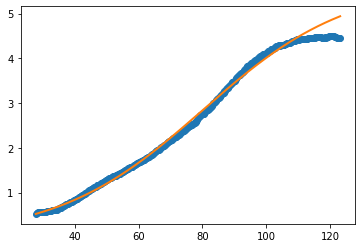

In [8]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds. 
###############################################################################

# arguments are initial values of tumor cell index and t cell count,
# time domain, measured cell index values
args = (x0, t, data_fit[:,1], data_sigma[:,1])

# manually specifying lower and upper bounds, 
# range identified by trial and error.
lb = [0,0]
ub = [1,2]

#lb = [0., 0., -10]
#ub = [1., 1., 10]

# run pso() as particle swarm optimization
xopt, fopt = pso(rms_growth, lb, ub, args = args, omega=1.1, phig=1.49, phip=1.49, swarmsize=20)
print(xopt, fopt)

# plot data and fitted curves
prediction = g_growth(t, x0, xopt)
plt.plot(t, data_fit[:,1], 'o')
plt.plot(t, prediction[:,0], '-', linewidth=2)
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 382
    # variables        = 2
    chi-square         = 174.526717
    reduced chi-square = 0.45928083
    Akaike info crit   = -295.236939
    Bayesian info crit = -287.346098
[[Variables]]
    rho:       0.04632238 +/- 1.8005e-04 (0.39%) (init = 0.04382367)
    kappainv:  0.19390897 +/- 0.00104357 (0.54%) (init = 0.1757195)
    c0:        0 (fixed)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.767


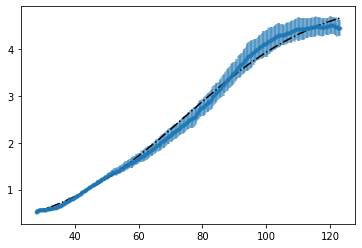

In [10]:
###############################################################################
#                     Growth (no dex) only:
###############################################################################
###############################################################################
#               Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.

params = Parameters()
# the .tolist() method is to convert the np.float64 dtype pso output into a float
# that will work with the function call to f(xs, t, ps)
params.add('rho', value=xopt[0], min=lb[0], max=ub[0], vary = True)  
params.add('kappainv', value=xopt[1], min=lb[1], max=ub[1], vary = True)
params.add('c0', value=0.0, min=-100, max=100, vary = False)
params.add('kappac1', value=0.0, min=0.0, max=40, vary = False)
params.add('kappac2', value=0.0, min=0.0, max=10, vary = False)
params.add('theta', value=0.0, min=0.0, max=10, vary = False)
params.add('c3', value=0.0, min=0.0, max=10, vary = False)

result_growth = minimize(residual_growth, params, args=(x0, t, data_fit[:,1], data_sigma[:,1]), method='leastsq')
final = data_fit[:,1] + result_growth.residual.reshape(data_fit[:,1].shape)
prediction = g_growth(t, x0, result_growth.params)

# Print report of fit.
print(fit_report(result_growth))
# plot data and fitted curves
#plt.plot(t, data_fit[:,1], 'o')
plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.5)
#plt.plot(t, final, '-', linewidth=2)
plt.plot(t, prediction[:,0], 'k-.')
plt.show()

In [58]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_interaction(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
        # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        if len(ps) == 3:
            rho = result_growth.params['rho'].value
            kappainv = result_growth.params['kappainv'].value
            c0 = result_growth.params['c0'].value
            c3 = result_growth.params['c3'].value
            kappac1, kappac2, theta = ps
        elif len(ps) == 7:
            rho, kappainv, kappac1, c0, kappac2, theta, c3 = ps

    x, y = xs

    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_interaction, x0, t, args=(ps,t_start))
    return x

def rms_tcell(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    rms = np.sqrt(np.mean(res**2))
    return rms

#def weight_fun(t, w_max, t_start):
#    return (w_max-1)*(np.exp(-0.05*(t-t_start)**2))+1

def residual_tcell(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g(ts, x0, ps)
#    weights = weight_fun(ts, 50, ts[0])
#    weights = weights/np.max(weights)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    return res

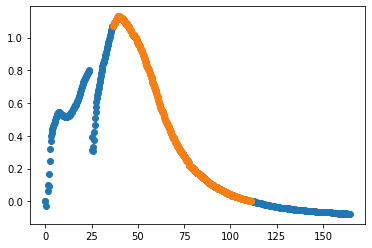

0.0022


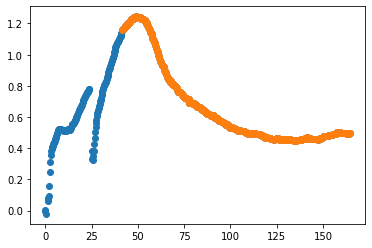

0.49495


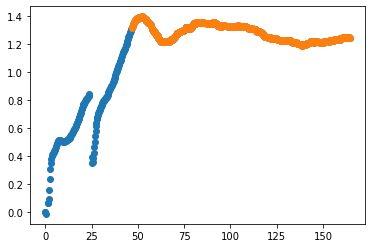

1.24585


In [12]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     CAR T cell treatment only:
#                     Re-define data to be used
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################


start_t = [140, 160, 180]
end_t = [440, 652, 652]
data_column_t = ['Y(B1,B2)', 'Y(C1,C2)', 'Y(D1,D2)']
sigma_column_t = ['SD(B1,B2)', 'SD(C1,C2)', 'SD(D1,D2)']
t_cell_start_t = [0.25, 0.125, 0.05]
dex_start_t = [0, 0, 0]

for i in range(0,3):

    data_full = np.array(data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]


    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    plt.plot(data_full[:,0], data_full[:,1], 'o')
    plt.plot(t, data_fit[:,1],'o')
    plt.show()
    print(data_fit[len(data_fit[:,1])-1,1])

Stopping search: Swarm best objective change less than 1e-08
[0.01731805 0.16972633 0.03510318] 2.058785879662975


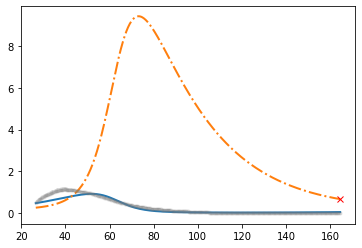

Stopping search: Swarm best objective change less than 1e-08
[0.09940638 0.14681274 0.08280525] 1.8694482664264522


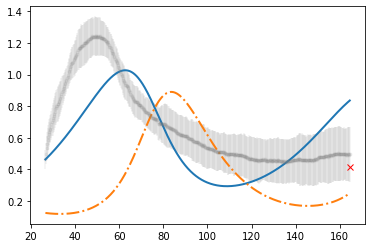

Stopping search: Swarm best objective change less than 1e-08
[5.02380345e-01 3.46485755e-03 1.00000000e-04] 34.85739247754584


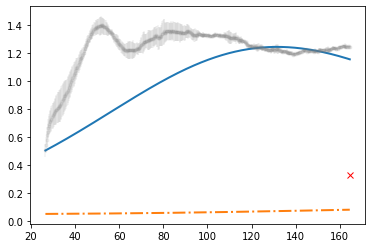

In [51]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt = []
t_fin_vec = [0.6598, 0.4155, 0.33095]

for i in range(0,3):
    
    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    t = data_fit[:,0]
    t_fin = t_fin_vec[i]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    # arguments are initial values of tumor cell index and t cell count,
    # time domain, measured cell index values
    args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])

    # manually specifying lower and upper bounds, 
    # range identified by trial and error.
    # Comment these differently defined bounds for using pso over entire parameter space or just some

    #lb = [1e-6, -1e0, -1e3]
    #ub = [1e-4, 1e0, 1e3]
    lb = np.array([[1e-2, 1e-2, 0], [1e-2, 1e-2, 1e-4], [1e-2, 1e-4, 1e-4]])
    ub = np.array([[1e0, 1e0, 5e-2], [1e0, 1e0, 1e-1], [1e0, 1e-1, 1e-1]])
    
    # run pso() as particle swarm optimization #  minfunc=1e-10, minstep=1e-10,
#    xopt_temp, fopt = pso(rms_tcell, lb[i], ub[i], args = args, maxiter=100, phig= 0.7, phip= 0.6, swarmsize=100)
    xopt_temp, fopt = pso(rms_tcell, lb[i], ub[i], args = args, omega=0.7, phig=1, phip=2, swarmsize=100, maxiter = 1000)
    xopt.append(xopt_temp)
    print(xopt[i], fopt)

    # plot data and fitted curves
    prediction = g(t, x0, xopt[i])
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
    plt.plot(t, prediction[:,0], '-', linewidth=2)
    plt.plot(t, prediction[:,1], '-.', linewidth=2)
    plt.plot(t[-1], t_fin, 'rx')
    plt.show()
    



In [63]:
#xopt[0] = xopt[1]
#xopt[2] = xopt[1]

#xopt[2] = [0.06343138, 0.08533304, 0.09132704]
result_growth.params['rho'].value = 0.15864674
result_growth.params['kappainv'].value = 0.73585573

#xopt

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 461
    # data points      = 553
    # variables        = 5
    chi-square         = 77.7585864
    reduced chi-square = 0.14189523
    Akaike info crit   = -1074.84721
    Bayesian info crit = -1053.27042
[[Variables]]
    rho:       0.30297207 +/- 0.00705741 (2.33%) (init = 0.1586467)
    kappainv:  0.32303399 +/- 0.00729641 (2.26%) (init = 0.7358557)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   0.55678451 +/- 0.02470033 (4.44%) (init = 0.01731805)
    kappac2:   0.02420882 +/- 0.00106254 (4.39%) (init = 0.1697263)
    theta:     8.5962e-14 +/- 3.0624e-04 (356247271544.06%) (init = 0.03510318)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, kappac2)  = -0.989
    C(rho, kappac1)      =  0.968
    C(kappac2, theta)    = -0.965
    C(rho, kappac2)      = -0.944
    C(kappainv, kappac2) =  0.933
    C(kappainv, kappac1) = -0.933
    C(kappac1, theta)    =  0.925
    C(r

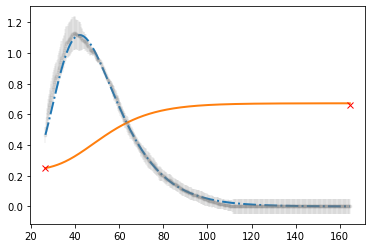

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 553
    # variables        = 5
    chi-square         = 54.0355159
    reduced chi-square = 0.09860496
    Akaike info crit   = -1276.12121
    Bayesian info crit = -1254.54442
[[Variables]]
    rho:       0.22550195 +/- 0.00256888 (1.14%) (init = 0.1586467)
    kappainv:  0.55293656 +/- 0.00441418 (0.80%) (init = 0.7358557)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   0.39659828 +/- 0.00948242 (2.39%) (init = 0.09940638)
    kappac2:   0.04773817 +/- 7.8536e-04 (1.65%) (init = 0.1468127)
    theta:     0.02402137 +/- 4.7865e-04 (1.99%) (init = 0.08280525)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)    =  0.970
    C(kappac1, kappac2)  = -0.888
    C(kappac1, theta)    = -0.798
    C(rho, kappac1)      =  0.694
    C(kappainv, kappac1) = -0.664
    C(kappainv, kappac2) =  0.596
    C(rho, theta)        = -0.582
    C(rho, kappac2)

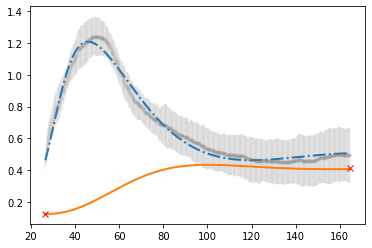

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 344
    # data points      = 553
    # variables        = 5
    chi-square         = 9354.15806
    reduced chi-square = 17.0696315
    Akaike info crit   = 1574.00468
    Bayesian info crit = 1595.58147
[[Variables]]
    rho:       0.11319272 +/- 0.00137014 (1.21%) (init = 0.1586467)
    kappainv:  0.51013836 +/- 0.00929469 (1.82%) (init = 0.7358557)
    c0:        0 (fixed)
    c3:        0 (fixed)
    kappac1:   0.90949137 +/- 0.06187737 (6.80%) (init = 0.06343138)
    kappac2:   0.08044974 +/- 0.00416322 (5.17%) (init = 0.08533304)
    theta:     0.09989047 +/- 0.00513905 (5.14%) (init = 0.09132704)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac2, theta)    =  1.000
    C(kappainv, kappac2) =  0.981
    C(kappainv, theta)   =  0.980
    C(rho, theta)        = -0.940
    C(rho, kappac2)      = -0.938
    C(rho, kappainv)     = -0.866
    C(kappainv, kappac1) = -0.717
    C(kappac1, kapp

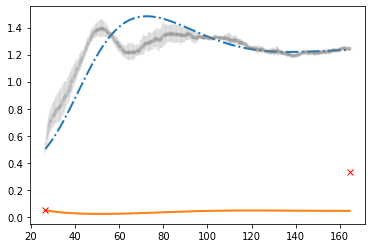

In [64]:
###############################################################################
#                     CAR T cell treatment only:
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.

start_t = [100, 100, 100]
end_t = [440, 652, 652]

result_tcell = []

for i in range(0,3):
    

    data_fit = np.array(data[['Time (Hour)', data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)

    t = data_fit[:,0]
    t_fin = t_fin_vec[i]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_t[i]])

    params0 = Parameters()
    # the .tolist() method is to convert the np.float64 dtype pso output into a float
    # that will work with the function call to f(xs, t, ps)
    params0.add('rho', value=result_growth.params['rho'], min=0.0, max=1, vary = True)  
    params0.add('kappainv', value=result_growth.params['kappainv'], min=0.1, max=2, vary = True)
    params0.add('c0', value=result_growth.params['c0'], min=-50, max=50, vary = False)
    params0.add('c3', value=result_growth.params['c3'], min=0, max=10, vary = False)
    params0.add('kappac1', value=xopt[i][0], min=lb[i][0], max=ub[i][0], vary = True)
    params0.add('kappac2', value=xopt[i][1], min=lb[i][1], max=ub[i][1], vary = True)
    params0.add('theta', value=xopt[i][2], min=lb[i][2], max=ub[i][2], vary = True)


    result_tcell_temp = minimize(residual_tcell, params0, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
    result_tcell.append(result_tcell_temp)
#    final = data_fit[:,1] + result_tcell[i].residual.reshape(data_fit[:,1].shape)
    prediction = g(t,x0,result_tcell[i].params)

    # Print report of fit.
    try:
        print(fit_report(result_tcell[i]))
    except:
        print('Errors not estimated')
    # plot data and fitted curves
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
#    plt.plot(t, final, '-', linewidth=2)
    plt.plot(t,prediction[:,0], '-.', linewidth = 2)
    plt.plot(t, prediction[:,1], '-', linewidth=2)
    plt.plot(t[-1], t_fin, 'rx')
    plt.plot(t[0], t_cell_start_t[i], 'rx')
    plt.show()

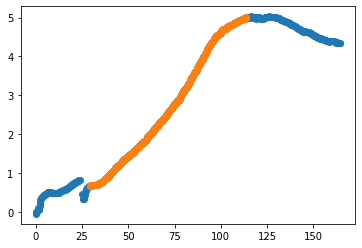

5.0046


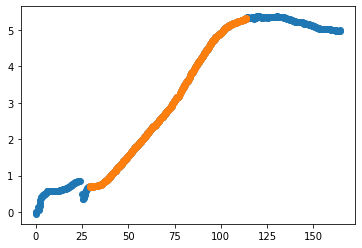

5.3324


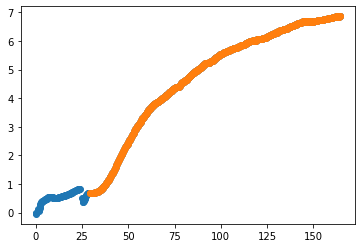

6.86725


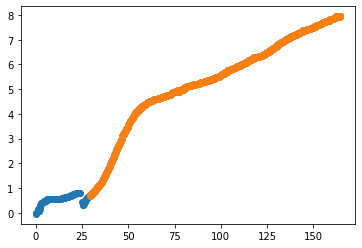

7.9498


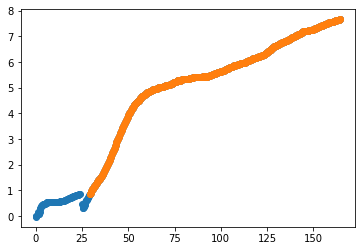

7.6631


In [70]:
###############################################################################
#                     Growth with Dex no T-cell
###############################################################################
###############################################################################
#                     Re-define data to be used.
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

start_gd = [110, 110, 110, 110, 110]
end_gd = [450, 450, 652, 652, 652]
data_column_gd = ['Y(A3,A4)', 'Y(A5,A6)', 'Y(A7,A8)', 'Y(A9,A10)', 'Y(A11,A12)']
sigma_column_gd = ['SD(A3,A4)', 'SD(A5,A6)', 'SD(A7,A8)', 'SD(A9,A10)', 'SD(A11,A12)']
t_cell_start_gd = [0, 0, 0, 0, 0]
dex_start_gd = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]

for i in range(0,5):
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]


    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    plt.plot(data_full[:,0], data_full[:,1], 'o')
    plt.plot(t, data_fit[:,1],'o')
    plt.show()
    print(data_fit[len(data_fit[:,1])-1,1])

In [72]:
result_growth.params['rho'].value = 0.04547757
result_growth.params['kappainv'].value = 0.1883974

Stopping search: Swarm best position change less than 1e-08
[0.01079638] 4.028643640918328


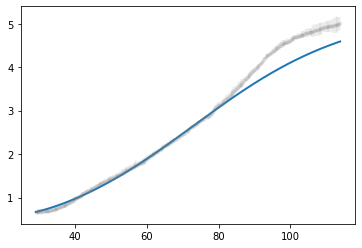

Stopping search: Swarm best objective change less than 1e-08
[-0.01504777] 2.5021611784971576


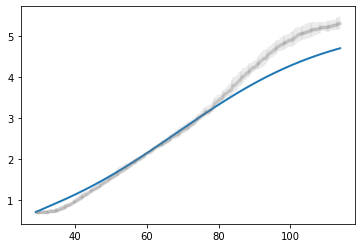

Stopping search: Swarm best objective change less than 1e-08
[-0.08936897] 3.6804517824589538


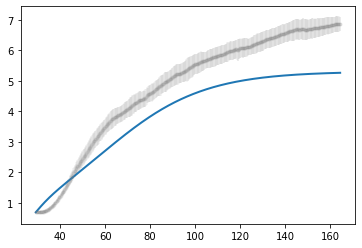

Stopping search: Swarm best objective change less than 1e-08
[-0.29416047] 50.616512796697315


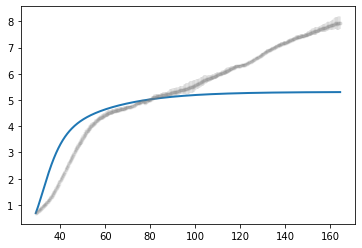

Stopping search: Swarm best objective change less than 1e-08
[-0.2207084] 9.192785862651515


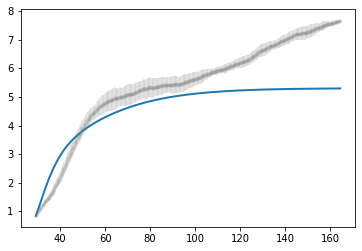

In [73]:
###############################################################################
#                     Growth no T-cell
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_gd = []


for i in range(0,5):
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_gd[i]]])[start_gd[i]:end_gd[i],:]


    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    # arguments are initial values of tumor cell index and t cell count,
    # time domain, measured cell index values
    args = (x0, t, data_fit[:,1], data_sigma[:,1])

    # manually specifying lower and upper bounds, 
    # range identified by trial and error.
    # Comment these differently defined bounds for using pso over entire parameter space or just some
    
    lb = np.array([[-100], [-100], [-100], [-100], [-100]])
    ub = np.array([[100], [100], [100], [100], [100]])
    #lb = np.array([[0., 0.], [0., 0.], [0., 0.]])
    #ub = np.array([[1., 1.], [1., 1.], [1., 1.]])
    #lb = np.array([[0., 0., -10], [0., 0., -10], [0., 0., -10]])
    #ub = np.array([[1., 1., 10], [1., 1., 10], [1., 1., 10]])
    
    # run pso() as particle swarm optimization
   
    xopt_temp, fopt = pso(rms_growth, lb[i], ub[i], args = args, maxiter=500, 
                          minfunc=1e-8, minstep=1e-8, phig=1, phip=2, omega = 0.7)
    xopt_gd.append(xopt_temp)
    print(xopt_gd[i], fopt)

    # plot data and fitted curves
    prediction = g_growth(t, x0, xopt_gd[i])
#    plt.plot(t, data_fit[:,1], 'o')
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')
    plt.plot(t, prediction[:,0], '-', linewidth=2)
    plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 340
    # variables        = 3
    chi-square         = 971.158110
    reduced chi-square = 2.88177481
    Akaike info crit   = 362.844848
    Bayesian info crit = 374.331685
[[Variables]]
    rho:       0.03511474 +/- 3.9978e-04 (1.14%) (init = 0.04547757)
    kappainv:  0.11848112 +/- 0.00241068 (2.03%) (init = 0.1883974)
    c0:       -0.02278188 +/- 0.00211683 (9.29%) (init = 0.01079638)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.970
    C(rho, kappainv) =  0.945
    C(kappainv, c0)  =  0.838


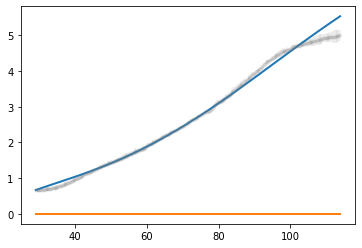

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 340
    # variables        = 3
    chi-square         = 235.617222
    reduced chi-square = 0.69916090
    Akaike info crit   = -118.690603
    Bayesian info crit = -107.203767
[[Variables]]
    rho:       0.04875576 +/- 4.3156e-04 (0.89%) (init = 0.04547757)
    kappainv:  0.16280287 +/- 0.00112027 (0.69%) (init = 0.1883974)
    c0:        0.01975921 +/- 0.00201894 (10.22%) (init = -0.01504777)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.948
    C(rho, kappainv) =  0.858
    C(kappainv, c0)  =  0.712


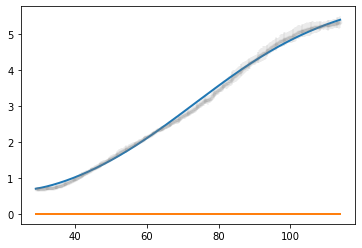

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 542
    # variables        = 3
    chi-square         = 837.138959
    reduced chi-square = 1.55313350
    Akaike info crit   = 241.620449
    Bayesian info crit = 254.506247
[[Variables]]
    rho:       0.06375493 +/- 9.0456e-04 (1.42%) (init = 0.04547757)
    kappainv:  0.15576729 +/- 6.6712e-04 (0.43%) (init = 0.1883974)
    c0:        0.00262430 +/- 0.00389014 (148.24%) (init = -0.08936897)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, c0)       =  0.825
    C(rho, kappainv) =  0.537
    C(kappainv, c0)  =  0.318


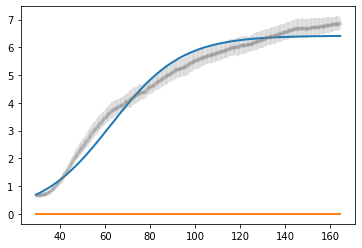

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 542
    # variables        = 3
    chi-square         = 11482.6259
    reduced chi-square = 21.3035731
    Akaike info crit   = 1660.90181
    Bayesian info crit = 1673.78761
[[Variables]]
    rho:       0.02379596 +/- 0.00124695 (5.24%) (init = 0.04547757)
    kappainv:  0.13124011 +/- 0.00206040 (1.57%) (init = 0.1883974)
    c0:       -0.28491216 +/- 0.00523749 (1.84%) (init = -0.2941605)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.996
    C(rho, c0)       =  0.996
    C(kappainv, c0)  =  0.985


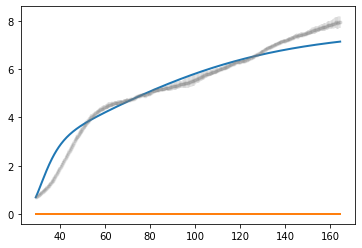

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 542
    # variables        = 3
    chi-square         = 1567.37687
    reduced chi-square = 2.90793483
    Akaike info crit   = 581.545854
    Bayesian info crit = 594.431652
[[Variables]]
    rho:       0.02073529 +/- 6.3553e-04 (3.06%) (init = 0.04547757)
    kappainv:  0.11539738 +/- 0.00136866 (1.19%) (init = 0.1883974)
    c0:       -0.23114555 +/- 0.00384227 (1.66%) (init = -0.2207084)
    kappac1:   0 (fixed)
    kappac2:   0 (fixed)
    theta:     0 (fixed)
    c3:        0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, kappainv) =  0.931
    C(rho, c0)       =  0.875
    C(kappainv, c0)  =  0.682


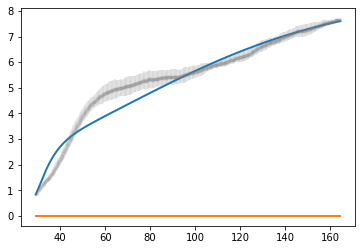

In [77]:
###############################################################################
#                     Growth no T-cell
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_growth_gd = []

for i in range(0,5):
    
    data_full = np.array(data[['Time (Hour)', data_column_gd[i]]])
    data_fit = np.array(data[['Time (Hour)', data_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    data_sigma = np.array(data[['Time (Hour)', sigma_column_gd[i]]])[start_gd[i]:end_gd[i],:]
    
    
    
    t = data_fit[:,0]

    ####### Your definition of x0 is for the initial populations,
    ## not the derivatives of the initial populations.
    ## Fix x0 definition to call on ode function to return dx/dt_0
    #######
    x0 = np.array([data_fit[0,1],t_cell_start_gd[i]])

    paramsgd = Parameters()
    # the .tolist() method is to convert the np.float64 dtype pso output into a float
    # that will work with the function call to f(xs, t, ps)
    #paramsgd.add('rho', value=xopt_gd[i][0], min=lb[i][0], max=ub[i][0], vary = True)  
    #paramsgd.add('kappainv', value=xopt_gd[i][1], min=lb[i][0], max=ub[i][0], vary = True)
    paramsgd.add('rho', value=result_growth.params['rho'], min=0, max=1, vary = True)  
    paramsgd.add('kappainv', value=result_growth.params['kappainv'], min=0, max=2, vary = True)
    paramsgd.add('c0', value=xopt_gd[i][0], min=-100, max=100, vary = True)
    paramsgd.add('kappac1', value=0, min=-1, max=1, vary = False)
    paramsgd.add('kappac2', value=0, min=-1, max=1, vary = False)
    paramsgd.add('theta', value=0, min=-1, max=1, vary = False)
    paramsgd.add('c3', value=0, min=-1, max=1, vary = False)


    result_growth_gd_temp = minimize(residual_growth, paramsgd, args=(x0, t, data_fit[:,1], data_sigma[:,1]), method='leastsq')
    result_growth_gd.append(result_growth_gd_temp)
    final = data_fit[:,1] + result_growth_gd[i].residual.reshape(data_fit[:,1].shape)

    # Print report of fit.
    try:
        print(fit_report(result_growth_gd[i]))
    except:
        print('Errors not estimated')
    # plot data and fitted curves
#    plt.plot(t, data_fit[:,1], 'o')
    prediction = g_growth(t, x0, result_growth_gd[i].params)
    plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
    plt.plot(t, prediction, '-', linewidth=2)
    plt.show()

In [87]:
###############################################################################
#                     T-cell with Dex
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_dt(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
        # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        if len(ps) == 3:
            # define result_growth_gd_now variable within loop that
            # calls this block.
            rho = result_growth_gd_now.params['rho'].value
            kappainv = result_growth_gd_now.params['kappainv'].value
            c0 = result_growth_gd_now.params['c0'].value
            theta = result_tcell_now.params['theta'].value
            kappac1, kappac2, c3 = ps
        elif len(ps) == 7:
            rho, kappainv, c0, kappac1, kappac2, theta, c3 = ps

    x, y = xs
    
    return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
            kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_dt(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_dt, x0, t, args=(ps,t_start))
    return x

def rms_dt(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g_dt(ts, x0, ps)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    rms = np.sqrt(np.mean(res**2))
    return rms
#def weight_fun(t, w_max, t_start):
#    return (w_max-1)*(np.exp(-0.0005*(t-t_start)**2))+1

#def residual_dt(ps, *args):
#    x0, ts, data = args
#    model = g_dt(ts, x0, ps)
#    weights = weight_fun(ts, 1, ts[0])
#    weights = weights/np.max(weights)
#    return ((model[:,0] - data)*weights).ravel()

def residual_dt(ps, *args):
    x0, ts, data, t_fin, sigma = args
    model = g_dt(ts, x0, ps)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, model[-1,1] - t_fin)
    weights = np.ones(len(res))
    weights[-1] = 50
    res = res*weights
    return res

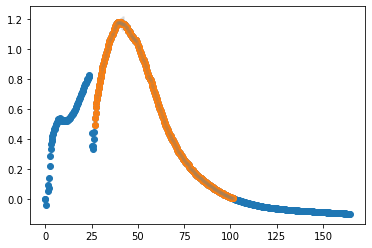

0.0061
DatasetY(B3,B4)


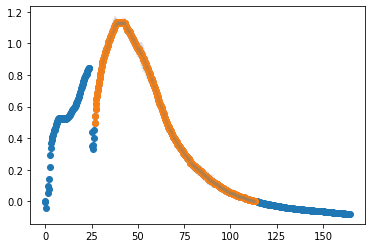

0.0016
DatasetY(B5,B6)


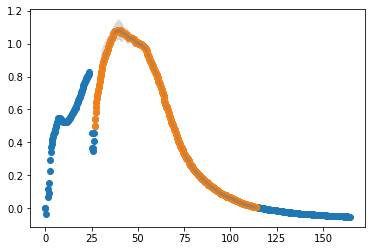

0.00695
DatasetY(B7,B8)


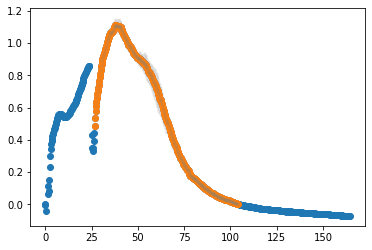

0.00215
DatasetY(B9,B10)


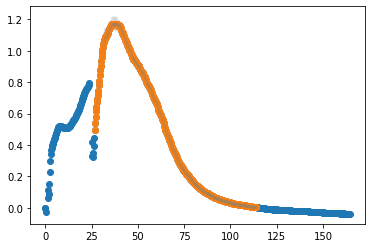

0.00455
DatasetY(B11,B12)


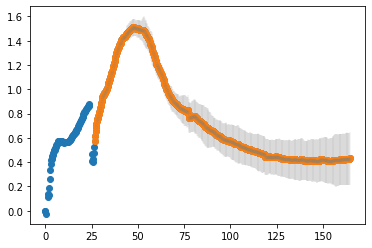

0.4305
DatasetY(C3,C4)


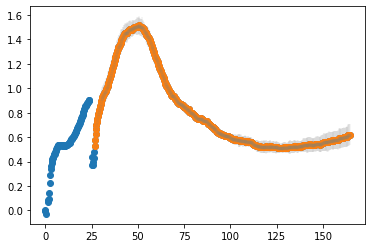

0.61915
DatasetY(C5,C6)


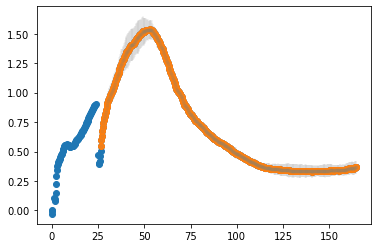

0.36525
DatasetY(C7,C8)


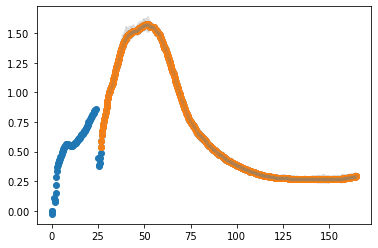

0.29325
DatasetY(C9,C10)


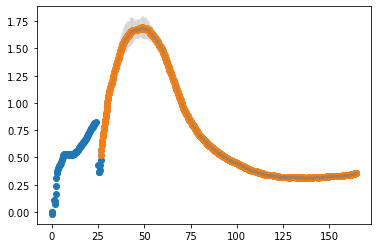

0.35355
DatasetY(C11,C12)


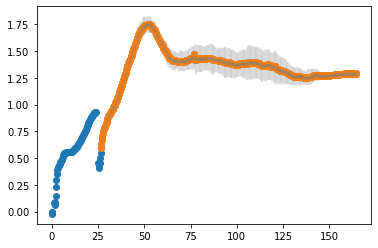

1.2917
DatasetY(D3,D4)


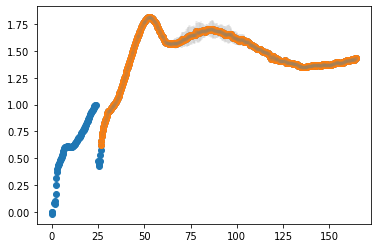

1.43285
DatasetY(D5,D6)


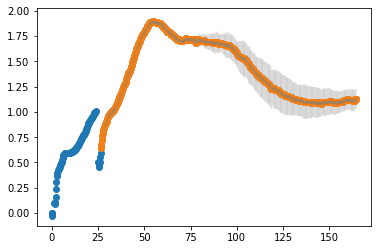

1.12875
DatasetY(D7,D8)


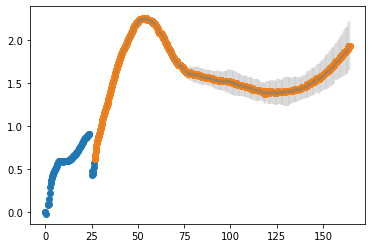

1.938
DatasetY(D9,D10)


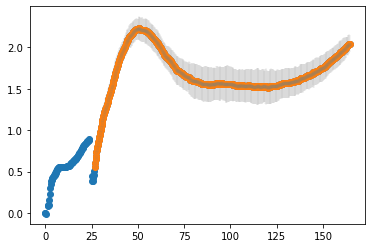

2.0449
DatasetY(D11,D12)


In [88]:
###############################################################################
#                     T-cell (0.25) with Dex
###############################################################################
###############################################################################
#                     Re-define data to be used.
#     User must specify start, end, data_column, and initial T Cell population.
#          Plotting is done to visualize data being accessed.
###############################################################################

## Need to decide ordering of loops for grabbing data columns.

data_column_dt = ['Y(B3,B4)', 'Y(B5,B6)', 'Y(B7,B8)', 'Y(B9,B10)', 'Y(B11,B12)',
                 'Y(C3,C4)', 'Y(C5,C6)', 'Y(C7,C8)', 'Y(C9,C10)', 'Y(C11,C12)',
                 'Y(D3,D4)', 'Y(D5,D6)', 'Y(D7,D8)', 'Y(D9,D10)', 'Y(D11,D12)']
sigma_column_dt = ['SD(B3,B4)', 'SD(B5,B6)', 'SD(B7,B8)', 'SD(B9,B10)', 'SD(B11,B12)',
                 'SD(C3,C4)', 'SD(C5,C6)', 'SD(C7,C8)', 'SD(C9,C10)', 'SD(C11,C12)',
                 'SD(D3,D4)', 'SD(D5,D6)', 'SD(D7,D8)', 'SD(D9,D10)', 'SD(D11,D12)']

start_dt = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
end_dt = [400, 448, 450, 410, 450, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652]
t_cell_start_dt = [0.25, 0.125, 0.05]
dex_start_dt = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
t_cell_fin_dt = [0.6596, 0.5282, 0.3724, 0.44495, 0.324,
                 0.4459, 0.3788, 0.2826, 0.2989, 0.26175,
                 0.3229, 0.2981, 0.3767, 0.2565, 0.2559]
count = 0
for i in range(0,3):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]

        t = data_fit[:,0]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
        plt.plot(data_full[:,0], data_full[:,1], 'o')
        plt.plot(t, data_fit[:,1],'o')
        plt.show()
        print(data_fit[len(data_fit[:,1])-1,1])
        print("Dataset" + str(data_column_dt[count]))
        count = count + 1

# Here we break the final fittings into three group, one for each
# T-cell concentration.  Also, will try experimenting with using the
# best fit of five as the initial guess for all.

Stopping search: Swarm best objective change less than 1e-08
[0.1        0.24016749 1.        ] 36.92046953982697


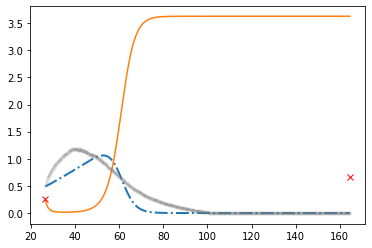

Stopping search: Swarm best objective change less than 1e-08
[0.25244347 0.15477756 0.76194728] 5.391538604877721


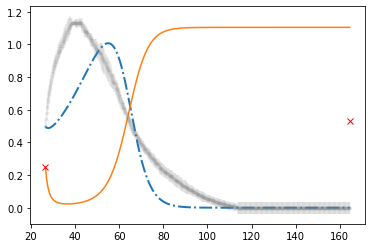

Stopping search: Swarm best objective change less than 1e-08
[ 0.06979773  0.04914185 -0.03285821] 10.198967396926195


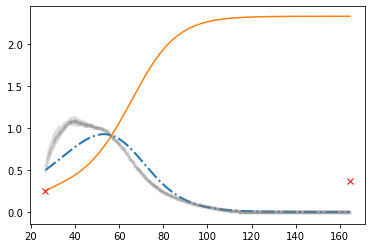

Stopping search: Swarm best objective change less than 1e-08
[0.71168527 0.04715577 0.47590808] 1.3500738016309428


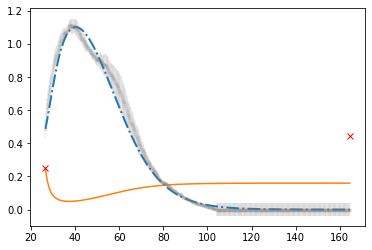

Stopping search: Swarm best objective change less than 1e-08
[0.28223519 0.04610375 0.29735317] 1.0310127189696785


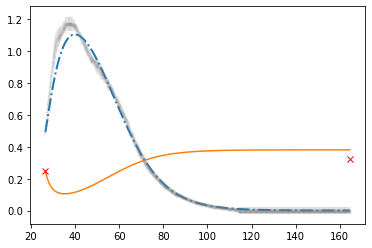

In [89]:
###############################################################################
#                     T-cell with Dex T-cell 1
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_dt_01 = []
#xopt_dt.pop(2)


# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-1, 1e-2, -1e0], [1e-2, 1e-2, -1e0], [1e-2, 1e-2, -1e0], [1e-2, 1e-3, -1e0], [1e-2, 1e-3, -1e0],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2]])
ub = np.array([[1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e1, 1e0, 1e0], [1e0, 1e-1, 1e0], [1e0, 1e-1, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 0
for i in range(0,1):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[j]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=1000,
                              minfunc=1e-8, minstep=1e-8, phig=1, phip=2, swarmsize=50, 
                              omega = 0.7)
        xopt_dt_01.append(xopt_temp)
        print(xopt_dt_01[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_01[j])

        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-')
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [91]:
xopt_dt_01[0] = xopt_dt_01[3]
#xopt_dt_01[1] = xopt_dt_01[3]
#xopt_dt_01[2] = xopt_dt_01[3]
xopt_dt_01

[array([0.71168527, 0.04715577, 0.47590808]),
 array([0.25244347, 0.15477756, 0.76194728]),
 array([ 0.06979773,  0.04914185, -0.03285821]),
 array([0.71168527, 0.04715577, 0.47590808]),
 array([0.28223519, 0.04610375, 0.29735317])]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 187
    # data points      = 553
    # variables        = 4
    chi-square         = 892.290983
    reduced chi-square = 1.62530234
    Akaike info crit   = 272.574163
    Bayesian info crit = 289.835595
[[Variables]]
    rho:       0.03511474 (fixed)
    kappainv:  0.1184811 (fixed)
    c0:       -0.20769261 +/- 0.00155525 (0.75%) (init = -0.02278188)
    kappac1:   0.19412658 +/- 0.00763790 (3.93%) (init = 0.7116853)
    kappac2:   0.04117955 +/- 3.1303e-04 (0.76%) (init = 0.04715577)
    theta:     0.0001 (fixed)
    c3:        0.15550762 +/- 0.00846007 (5.44%) (init = 0.4759081)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.980
    C(c0, kappac1) = -0.975
    C(c0, c3)      = -0.914
    C(kappac2, c3) =  0.254
    C(c0, kappac2) =  0.152


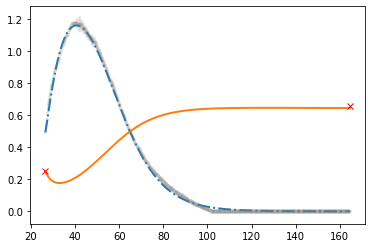

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 553
    # variables        = 4
    chi-square         = 61.6055375
    reduced chi-square = 0.11221409
    Akaike info crit   = -1205.61725
    Bayesian info crit = -1188.35582
[[Variables]]
    rho:       0.04875576 (fixed)
    kappainv:  0.1628029 (fixed)
    c0:       -0.20647711 +/- 8.5467e-04 (0.41%) (init = 0.01975921)
    kappac1:   0.22901595 +/- 0.00297504 (1.30%) (init = 0.2524435)
    kappac2:   0.02841805 +/- 2.4402e-04 (0.86%) (init = 0.1547776)
    theta:     0.0001 (fixed)
    c3:        0.09569780 +/- 0.00336104 (3.51%) (init = 0.7619473)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.900
    C(c0, kappac1)      = -0.621
    C(kappac2, c3)      =  0.615
    C(c0, kappac2)      =  0.538
    C(c0, c3)           = -0.249
    C(kappac1, kappac2) =  0.222


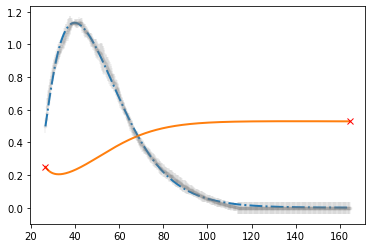

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 553
    # variables        = 4
    chi-square         = 1825.56253
    reduced chi-square = 3.32525050
    Akaike info crit   = 668.439854
    Bayesian info crit = 685.701286
[[Variables]]
    rho:       0.06375493 (fixed)
    kappainv:  0.1557673 (fixed)
    c0:       -0.18081351 +/- 0.00633198 (3.50%) (init = 0.002624296)
    kappac1:   0.37570172 +/- 0.03597646 (9.58%) (init = 0.06979773)
    kappac2:   0.03107535 +/- 1.7316e-04 (0.56%) (init = 0.04914185)
    theta:     0.0001 (fixed)
    c3:        0.20688438 +/- 0.01989167 (9.61%) (init = -0.03285821)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.998
    C(c0, kappac1) = -0.977
    C(c0, c3)      = -0.964
    C(c0, kappac2) =  0.193


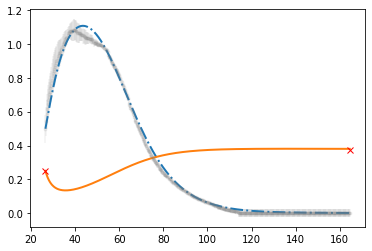

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 553
    # variables        = 4
    chi-square         = 675.421214
    reduced chi-square = 1.23027544
    Akaike info crit   = 118.588119
    Bayesian info crit = 135.849551
[[Variables]]
    rho:       0.02379596 (fixed)
    kappainv:  0.1312401 (fixed)
    c0:       -0.20741616 +/- 0.00269365 (1.30%) (init = -0.2849122)
    kappac1:   0.25513089 +/- 0.01230194 (4.82%) (init = 0.7116853)
    kappac2:   0.05380971 +/- 7.3072e-04 (1.36%) (init = 0.04715577)
    theta:     0.0001 (fixed)
    c3:        0.31144622 +/- 0.01179591 (3.79%) (init = 0.4759081)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.883
    C(c0, kappac2) =  0.700
    C(c0, kappac1) = -0.638
    C(kappac2, c3) =  0.518
    C(c0, c3)      = -0.240


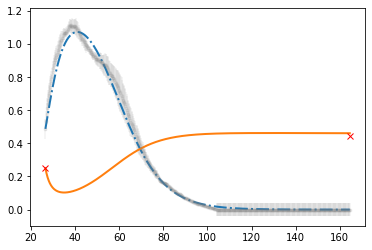

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 553
    # variables        = 4
    chi-square         = 587.339119
    reduced chi-square = 1.06983446
    Akaike info crit   = 41.3151351
    Bayesian info crit = 58.5765671
[[Variables]]
    rho:       0.02073529 (fixed)
    kappainv:  0.1153974 (fixed)
    c0:       -0.23462763 +/- 0.00274928 (1.17%) (init = -0.2311456)
    kappac1:   0.29936423 +/- 0.01732701 (5.79%) (init = 0.2822352)
    kappac2:   0.04596670 +/- 3.4207e-04 (0.74%) (init = 0.04610375)
    theta:     0.0001 (fixed)
    c3:        0.30746755 +/- 0.01229859 (4.00%) (init = 0.2973532)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.977
    C(c0, kappac1) = -0.929
    C(c0, c3)      = -0.833
    C(c0, kappac2) =  0.349
    C(kappac2, c3) =  0.225


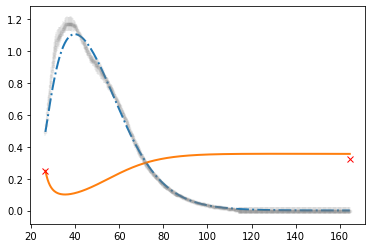

In [92]:
###############################################################################
#                     T-cell with Dex T cell 1
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_01 = []
#result_dt.pop(2)

count = 0

for i in range(0,1):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)

        
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_growth_gd[j].params['rho'], min=0.0, max=1, vary = False)  
        paramsdt.add('kappainv', value=result_growth_gd[j].params['kappainv'], min=0.01, max=2, vary = False)
        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min=-10, max=10, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_01[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_01[j][1], min=lb[count][1], max=ub[count][1], vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min= 1e-4, max=1, vary = False)
        paramsdt.add('c3', value=xopt_dt_01[count][2], min=lb[count][2], max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
        result_dt_01.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_01[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t,x0,result_dt_01[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_01[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
        #plt.plot(t, data_fit[:,1], 'o')
        #plt.plot(t, final, '-', linewidth=2)
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

Stopping search: Swarm best objective change less than 1e-08
[0.01608417 0.20023644 1.        ] 69.2273471950871


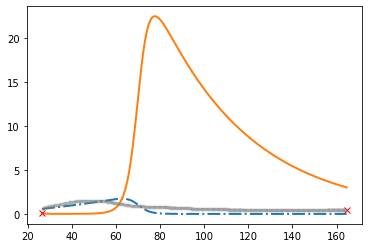

Stopping search: maximum iterations reached --> 1000
[1.1138419  0.07502174 0.4704819 ] 7.537331137934571


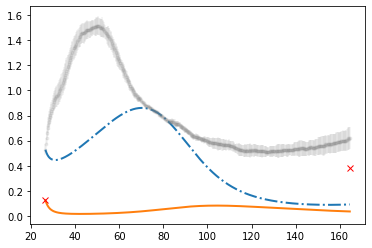

Stopping search: Swarm best objective change less than 1e-08
[ 0.06886563  0.04639143 -0.26816546] 3.0628902901821657


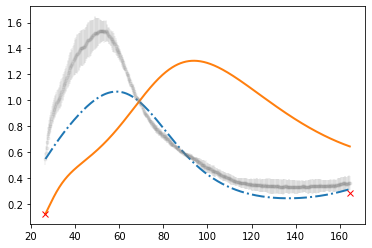

Stopping search: Swarm best objective change less than 1e-08
[0.59859735 0.03417395 0.27916211] 1.5991394713092855


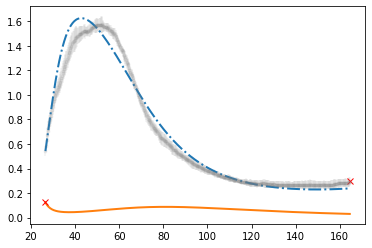

Stopping search: Swarm best position change less than 1e-08
[0.32343564 0.03918761 0.21541935] 8.311636712489312


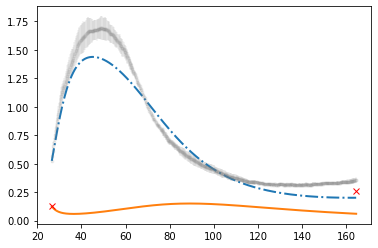

In [93]:
###############################################################################
#                     T-cell with Dex T-cell 2
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_dt_02 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-3, 1e-2, -1e0], [1e-3, 1e-2, -1e0], [1e-3, 1e-2, -1e0], [1e-3, 1e-2, -1e0], [1e-3, 1e-2, -1e0],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2]])
ub = np.array([[1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e1, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e1, 1e0, 1e0], [1e1, 1e0, 1e0], [1e1, 1e0, 1e0], [1e1, 1e0, 1e0], [1e1, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 5
for i in range(1,2):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=1000, 
                              minfunc=1e-8, minstep=1e-8, phig=1, phip=2, swarmsize=50,
                             omega = 0.7)
        xopt_dt_02.append(xopt_temp)
        print(xopt_dt_02[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_02[j])
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
#        plt.plot(t, data_fit[:,1], 'o')
        plt.plot(t, prediction[:,0], '-.', linewidth=2)
        plt.plot(t, prediction[:,1], '-', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        
        plt.show()
    
        count = count + 1

In [95]:
xopt_dt_02[0] = xopt_dt_02[2]
xopt_dt_02[1] = xopt_dt_02[2]
xopt_dt_02[3] = xopt_dt_02[2]
xopt_dt_02[4] = xopt_dt_02[2]
#xopt_dt_02

#xopt_dt_02[0][2] = 0.03
#xopt_dt_02[1][2] = 0.03
#xopt_dt_02[2][2] = 0.03
#xopt_dt_02[3][2] = 0.03
#xopt_dt_02[4][2] = 0.03
xopt_dt_02

[array([ 0.06886563,  0.04639143, -0.26816546]),
 array([ 0.06886563,  0.04639143, -0.26816546]),
 array([ 0.06886563,  0.04639143, -0.26816546]),
 array([ 0.06886563,  0.04639143, -0.26816546]),
 array([ 0.06886563,  0.04639143, -0.26816546])]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 553
    # variables        = 4
    chi-square         = 3537.18228
    reduced chi-square = 6.44295498
    Akaike info crit   = 1034.21743
    Bayesian info crit = 1051.47886
[[Variables]]
    rho:       0.03511474 (fixed)
    kappainv:  0.1184811 (fixed)
    c0:       -0.14435260 +/- 0.00156956 (1.09%) (init = -0.02278188)
    kappac1:   0.06106258 +/- 0.00711101 (11.65%) (init = 0.06886563)
    kappac2:   0.03948267 +/- 8.7680e-04 (2.22%) (init = 0.04639143)
    theta:     0.02402137 (fixed)
    c3:       -0.16914563 +/- 0.02649767 (15.67%) (init = -0.2681655)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.956
    C(c0, kappac1) = -0.796
    C(c0, c3)      = -0.586
    C(c0, kappac2) =  0.387
    C(kappac2, c3) =  0.273


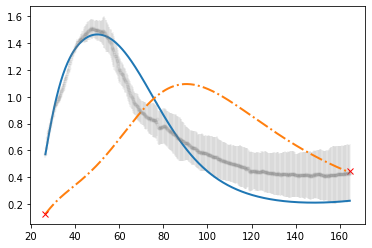

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 553
    # variables        = 4
    chi-square         = 1452.68900
    reduced chi-square = 2.64606376
    Akaike info crit   = 542.094921
    Bayesian info crit = 559.356353
[[Variables]]
    rho:       0.04875576 (fixed)
    kappainv:  0.1628029 (fixed)
    c0:       -0.16280618 +/- 0.00286864 (1.76%) (init = 0.01975921)
    kappac1:   0.08861962 +/- 0.00771217 (8.70%) (init = 0.06886563)
    kappac2:   0.02819088 +/- 2.2325e-04 (0.79%) (init = 0.04639143)
    theta:     0.02402137 (fixed)
    c3:       -0.27890384 +/- 0.01838319 (6.59%) (init = -0.2681655)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.997
    C(c0, kappac2) =  0.673
    C(c0, kappac1) = -0.665
    C(c0, c3)      = -0.612
    C(kappac2, c3) =  0.148


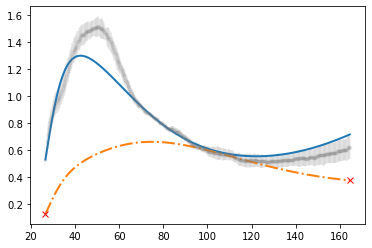

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 553
    # variables        = 4
    chi-square         = 1193.99749
    reduced chi-square = 2.17485882
    Akaike info crit   = 433.646417
    Bayesian info crit = 450.907849
[[Variables]]
    rho:       0.06375493 (fixed)
    kappainv:  0.1557673 (fixed)
    c0:       -0.12338652 +/- 0.00382316 (3.10%) (init = 0.002624296)
    kappac1:   0.14948809 +/- 0.01594745 (10.67%) (init = 0.06886563)
    kappac2:   0.03546586 +/- 2.3110e-04 (0.65%) (init = 0.04639143)
    theta:     0.02402137 (fixed)
    c3:       -0.14060808 +/- 0.02240840 (15.94%) (init = -0.2681655)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.998
    C(c0, kappac1) = -0.749
    C(c0, c3)      = -0.726
    C(c0, kappac2) =  0.594


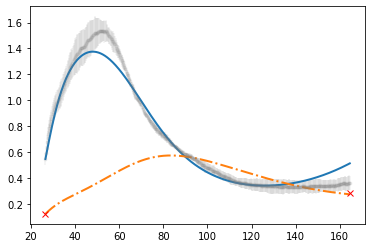

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 553
    # variables        = 4
    chi-square         = 1225.81824
    reduced chi-square = 2.23282011
    Akaike info crit   = 448.191235
    Bayesian info crit = 465.452667
[[Variables]]
    rho:       0.02379596 (fixed)
    kappainv:  0.1312401 (fixed)
    c0:       -0.22916206 +/- 0.00216338 (0.94%) (init = -0.2849122)
    kappac1:   0.05655612 +/- 0.00531312 (9.39%) (init = 0.06886563)
    kappac2:   0.03398371 +/- 2.9635e-04 (0.87%) (init = 0.04639143)
    theta:     0.02402137 (fixed)
    c3:       -0.21425725 +/- 0.02027501 (9.46%) (init = -0.2681655)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.986
    C(c0, kappac2)      =  0.727
    C(c0, kappac1)      = -0.487
    C(c0, c3)           = -0.367
    C(kappac2, c3)      =  0.251
    C(kappac1, kappac2) =  0.102


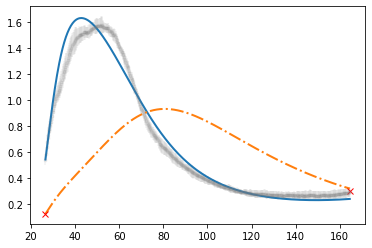

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 136
    # data points      = 553
    # variables        = 4
    chi-square         = 8183.36241
    reduced chi-square = 14.9059425
    Akaike info crit   = 1498.05872
    Bayesian info crit = 1515.32015
[[Variables]]
    rho:       0.02073529 (fixed)
    kappainv:  0.1153974 (fixed)
    c0:       -0.34559394 +/- 0.00496976 (1.44%) (init = -0.2311456)
    kappac1:   0.03458027 +/- 0.00709305 (20.51%) (init = 0.06886563)
    kappac2:   0.02069735 +/- 3.8195e-04 (1.85%) (init = 0.04639143)
    theta:     0.02402137 (fixed)
    c3:       -0.41738157 +/- 0.04365653 (10.46%) (init = -0.2681655)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.996
    C(c0, kappac2)      =  0.766
    C(c0, kappac1)      = -0.507
    C(c0, c3)           = -0.432
    C(kappac2, c3)      =  0.200
    C(kappac1, kappac2) =  0.112


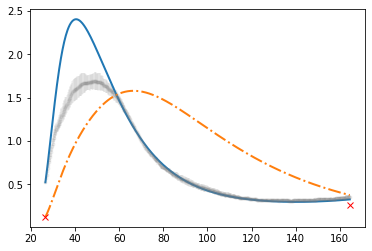

In [98]:
###############################################################################
#                     T-cell with Dex T cell 2
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_02 = []
#result_dt.pop(2)

count = 5

for i in range(1,2):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)

        
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_growth_gd[j].params['rho'], min=0.0, max=1, vary = False)  
        paramsdt.add('kappainv', value=result_growth_gd[j].params['kappainv'], min=0.01, max=2, vary = False)
        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min=-10, max=10, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_02[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_02[j][1], min=lb[count][1], max=ub[count][1], vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min=1e-6, max=1, vary = False)
        paramsdt.add('c3', value=xopt_dt_02[j][2], min=lb[count][2], max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
        result_dt_02.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_02[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t, x0, result_dt_02[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_02[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    

#        plt.plot(t, data_fit[:,1], 'o')
#        plt.plot(t, final, '-', linewidth=2)
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
        plt.plot(t, prediction[:,0], '-', linewidth=2)
        plt.plot(t, prediction[:,1], '-.', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

Stopping search: Swarm best objective change less than 1e-08
[ 0.02575834  0.05317307 -0.79109067] 9.367277830330812


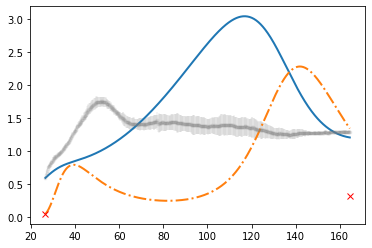

Stopping search: Swarm best objective change less than 1e-08
[ 0.01        0.05707642 -0.91388804] 130.61087253956245


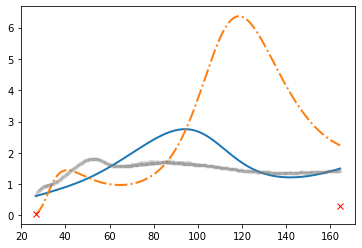

Stopping search: Swarm best objective change less than 1e-08
[ 0.02047292  0.10483659 -0.52403217] 32.69382932133305


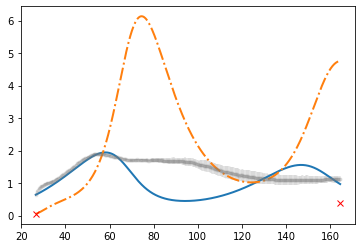

Stopping search: Swarm best objective change less than 1e-08
[1.         0.0487371  0.14212364] 7.039177211162114


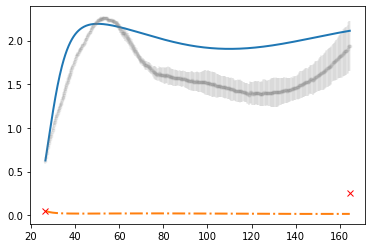

Stopping search: Swarm best objective change less than 1e-08
[ 0.03909059  0.05782899 -0.50103688] 0.9123718802618866


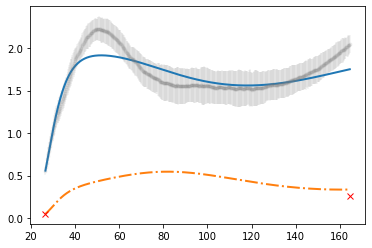

In [99]:
###############################################################################
#                     T-cell with Dex T-cell 3
###############################################################################
###############################################################################
#                     Set up and run Particle Swarm Optimization
#                     Define arguments and lower and upper bounds.
#                     Some guess and check work still done to identify
#                     approximate range of upper and lower bounds. 
###############################################################################

xopt_dt_03 = []
#xopt_dt.pop(2)

# manually specifying lower and upper bounds, 
# range identified by trial and error.
# Comment these differently defined bounds for using pso over entire parameter space or just some
lb = np.array([[1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2], [1e-2, 1e-2, 1e-2],
               [1e-2, 1e-3, -1e0], [1e-2, 1e-3, -1e0], [1e-2, 1e-3, -1e0], [1e-2, 1e-3, -1e0], [1e-2, 1e-3, -1e0]])
ub = np.array([[1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e1, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0],
              [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0], [1e0, 1e0, 1e0]])
#    lb = np.array([[0.1, 1e-3, -50, 1e-4, 1e-4, 1e-4], [1e-2, 1e-3, 0, 1e-5, 1e-3, 1e-3], [0.0, 0.01, -100, 1e-7, 1e-3, 1e-7]])
#    ub = np.array([[1, 1, 0, 1e-2, 1e-2, 1e-2], [1, 1, 50, 1e-3, 1e-1, 1e-1], [5, 10, 50, 1e-3, 1e1, 1e-4]])

count = 10
for i in range(2,3):
    for j in range(0,5):
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[count]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]
    
        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        # arguments are initial values of tumor cell index and t cell count,
        # time domain, measured cell index values
        args = (x0, t, data_fit[:,1], t_fin, data_sigma[:,1])
        result_growth_gd_now = result_growth_gd[j]
        result_tcell_now = result_tcell[i]

    
        # run pso() as particle swarm optimization
   
        xopt_temp, fopt = pso(rms_dt, lb[count], ub[count], args = args, maxiter=1000, 
                              minfunc=1e-8, minstep=1e-8, phig=1, phip=2, swarmsize=50,
                             omega = 0.7)
        xopt_dt_03.append(xopt_temp)
        print(xopt_dt_03[j], fopt)

        # plot data and fitted curves
        prediction = g_dt(t, x0, xopt_dt_03[j])
#        plt.plot(t, data_fit[:,1], 'o')
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')    
        plt.plot(t, prediction[:,0], '-', linewidth=2)
        plt.plot(t, prediction[:,1], '-.', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
    
        count = count + 1

In [104]:
#xopt_dt_03[0] = xopt_dt_03[2]
#xopt_dt_03[1] = xopt_dt_03[2]
#xopt_dt_03[3] = xopt_dt_03[2]
#xopt_dt_03[4] = xopt_dt_03[2]
#print(xopt_dt_03[0])
#print(xopt_dt_03[1])
#print(xopt_dt_03[2])
#print(xopt_dt_03[2])
#print(xopt_dt_03[4])
#xopt_dt_03[3][0] = 10
#xopt_dt_03[3][1] = 0.075
#xopt_dt_03[3][2] = 0.075

xopt_dt_03[1] = xopt_dt_03[0]
xopt_dt_03[2] = xopt_dt_03[0]
#xopt_dt_03[3] = xopt_dt_03[4]


#xopt_dt_03[2][1] = 0.075
#xopt_dt_03[2][2] = 0.5

#xopt_dt_03[0][2] = 0.0)
#xopt_dt_03[1][2] = 0.03
#xopt_dt_03[2][2] = 0.03
#xopt_dt_03[3][2] = 0.03
#xopt_dt_03[4][2] = 0.03
#xopt_dt_03
result_growth_gd[4].params

name,value,standard error,relative error,initial value,min,max,vary
rho,0.02073529,6.3553e-04,(3.06%),,0.00000000,1.00000000,True
kappainv,0.11539738,0.00136866,(1.19%),,0.00000000,2.00000000,True
c0,-0.23114555,0.00384227,(1.66%),-0.2207084008477343,-100.000000,100.000000,True
kappac1,0.00000000,0.00000000,,0,-1.00000000,1.00000000,False
kappac2,0.00000000,0.00000000,,0,-1.00000000,1.00000000,False
theta,0.00000000,0.00000000,,0,-1.00000000,1.00000000,False
c3,0.00000000,0.00000000,,0,-1.00000000,1.00000000,False


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 204
    # data points      = 553
    # variables        = 4
    chi-square         = 1794.48854
    reduced chi-square = 3.26864944
    Akaike info crit   = 658.945880
    Bayesian info crit = 676.207312
[[Variables]]
    rho:       0.03511474 (fixed)
    kappainv:  0.1184811 (fixed)
    c0:       -0.10715625 +/- 0.00148510 (1.39%) (init = -0.48)
    kappac1:   0.07933185 +/- 0.00911942 (11.50%) (init = 0.02047292)
    kappac2:   0.07516485 +/- 4.3121e-04 (0.57%) (init = 0.1048366)
    theta:     0.09989047 (fixed)
    c3:       -0.45205045 +/- 0.02417482 (5.35%) (init = -0.5240322)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.989
    C(c0, kappac1) = -0.907
    C(c0, c3)      = -0.861
    C(c0, kappac2) = -0.189


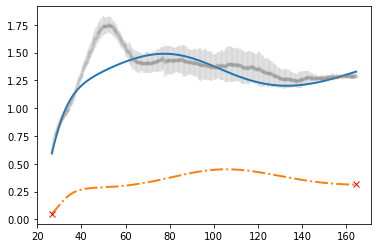

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 146
    # data points      = 553
    # variables        = 4
    chi-square         = 1514869.34
    reduced chi-square = 2759.32485
    Akaike info crit   = 4385.26141
    Bayesian info crit = 4402.52284
[[Variables]]
    rho:       0.04875576 (fixed)
    kappainv:  0.1628029 (fixed)
    c0:       -0.13534782 +/- 0.49141929 (363.08%) (init = -0.35)
    kappac1:   0.53190739 +/- 8.82135806 (1658.44%) (init = 0.02047292)
    kappac2:   0.06648015 +/- 3.1331e-04 (0.47%) (init = 0.1048366)
    theta:     0.09989047 (fixed)
    c3:       -0.11915502 +/- 3.45638396 (2900.75%) (init = -0.5240322)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  1.000
    C(c0, c3)      = -1.000
    C(c0, kappac1) = -1.000


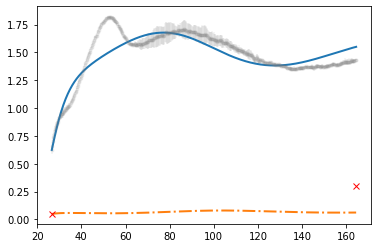

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 553
    # variables        = 4
    chi-square         = 71469.0553
    reduced chi-square = 130.180429
    Akaike info crit   = 2696.49900
    Bayesian info crit = 2713.76043
[[Variables]]
    rho:       0.06375493 (fixed)
    kappainv:  0.1557673 (fixed)
    c0:       -0.04730957 +/- 0.00227688 (4.81%) (init = -0.1199)
    kappac1:   0.06401245 +/- 0.01429826 (22.34%) (init = 0.02047292)
    kappac2:   0.07860359 +/- 5.3894e-04 (0.69%) (init = 0.1048366)
    theta:     0.09989047 (fixed)
    c3:       -0.48922648 +/- 0.04799870 (9.81%) (init = -0.5240322)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3)      =  0.996
    C(c0, kappac1)      = -0.924
    C(c0, c3)           = -0.890
    C(kappac2, c3)      =  0.297
    C(kappac1, kappac2) =  0.211
    C(c0, kappac2)      =  0.147


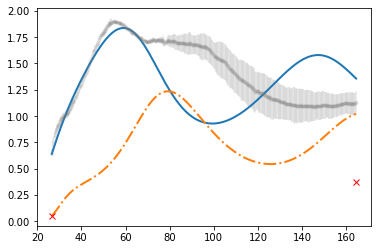

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 553
    # variables        = 4
    chi-square         = 8843.77901
    reduced chi-square = 16.1088871
    Akaike info crit   = 1540.97769
    Bayesian info crit = 1558.23912
[[Variables]]
    rho:       0.02379596 (fixed)
    kappainv:  0.1312401 (fixed)
    c0:       -0.20625344 +/- 0.00114747 (0.56%) (init = -0.277)
    kappac1:   0.02420067 +/- 0.00575396 (23.78%) (init = 0.03909059)
    kappac2:   0.06538050 +/- 7.0496e-04 (1.08%) (init = 0.05782899)
    theta:     0.09989047 (fixed)
    c3:       -0.43349064 +/- 0.04970133 (11.47%) (init = -0.5010369)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.989
    C(c0, kappac1) = -0.767
    C(c0, c3)      = -0.671
    C(c0, kappac2) =  0.542


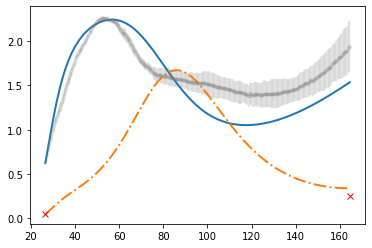

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 553
    # variables        = 4
    chi-square         = 179.950777
    reduced chi-square = 0.32777919
    Akaike info crit   = -612.839080
    Bayesian info crit = -595.577648
[[Variables]]
    rho:       0.02073529 (fixed)
    kappainv:  0.1153974 (fixed)
    c0:       -0.25738562 +/- 9.0042e-04 (0.35%) (init = -0.263)
    kappac1:   0.04322737 +/- 0.00191845 (4.44%) (init = 0.03909059)
    kappac2:   0.05582132 +/- 1.3552e-04 (0.24%) (init = 0.05782899)
    theta:     0.09989047 (fixed)
    c3:       -0.48853533 +/- 0.00938342 (1.92%) (init = -0.5010369)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, c3) =  0.977
    C(c0, kappac2) =  0.477
    C(c0, kappac1) = -0.199
    C(c0, c3)      = -0.156


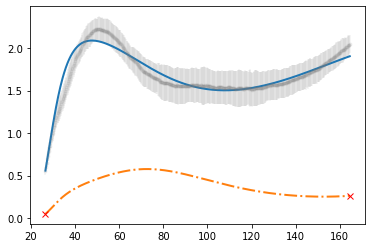

In [108]:
###############################################################################
#                     T-cell with Dex T cell 3
###############################################################################
###############################################################################
#             Set up and run lmfit to extract goodness of fit statistics
###############################################################################

# Define the params object (special to lmfit) that has the output from 
# particle swarm optimization.
result_dt_03 = []
#result_dt.pop(2)

count = 10

new_c0 = np.array([-0.48, -0.35, -0.1199, -0.277, -0.263])

for i in range(2,3):
    for j in range(0,5):
    
        data_full = np.array(data[['Time (Hour)', data_column_dt[count]]])
        data_fit = np.array(data[['Time (Hour)', data_column_dt[count]]])[start_dt[count]:end_dt[count],:]
        data_sigma = np.array(data[['Time (Hour)', sigma_column_dt[count]]])[start_dt[count]:end_dt[count],:]
    
        if end_dt[count] != 652:
            new_time = np.array(data[['Time (Hour)']])[end_dt[j]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_dt[count]
            # append zeros to data_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)

        
        t = data_fit[:,0]
        t_fin = t_cell_fin_dt[count]

        ####### Your definition of x0 is for the initial populations,
        ## not the derivatives of the initial populations.
        ## Fix x0 definition to call on ode function to return dx/dt_0
        #######
        x0 = np.array([data_fit[0,1],t_cell_start_dt[i]])

        paramsdt = Parameters()
        # the .tolist() method is to convert the np.float64 dtype pso output into a float
        # that will work with the function call to f(xs, t, ps)
        paramsdt.add('rho', value=result_growth_gd[j].params['rho'], min=0.0, max=1, vary = False)  
        paramsdt.add('kappainv', value=result_growth_gd[j].params['kappainv'], min=0.01, max=2, vary = False)
#        paramsdt.add('c0', value=result_growth_gd[j].params['c0'], min=-10, max=-1e-10, vary = True)
#        paramsdt.add('c0', value=-0.15, min=-10, max=-1e-10, vary = True)
        paramsdt.add('c0', value=new_c0[j], min=-10, max=-1e-10, vary = True)
        paramsdt.add('kappac1', value=xopt_dt_03[j][0], min=lb[count][0], max=ub[count][0], vary = True)
        paramsdt.add('kappac2', value=xopt_dt_03[j][1], min=lb[count][1], max=0.5, vary = True)
        paramsdt.add('theta', value=result_tcell[i].params['theta'], min=1e-2, max=1, vary = False)
        paramsdt.add('c3', value=xopt_dt_03[j][2], min=lb[count][2], max=ub[count][2], vary = True)
    

        result_dt_temp = minimize(residual_dt, paramsdt, args=(x0, t, data_fit[:,1], t_fin, data_sigma[:,1]), method='leastsq')
        result_dt_03.append(result_dt_temp)
#        final = data_fit[:,1] + result_dt_03[j].residual.reshape(data_fit[:,1].shape)
        prediction = g_dt(t, x0, result_dt_03[j].params)

        # Print report of fit.
        try:
            print(fit_report(result_dt_03[j]))
        except:
            print('Errors not estimated')
        # plot data and fitted curves
    

#        plt.plot(t, data_fit[:,1], 'o')
#        plt.plot(t, final, '-', linewidth=2)
        plt.errorbar(t, data_fit[:,1], data_sigma[:,1], fmt = '.', alpha = 0.1, color = 'grey')            
        plt.plot(t, prediction[:,0], '-', linewidth=2)
        plt.plot(t, prediction[:,1], '-.', linewidth=2)
        plt.plot(t[-1], t_fin, 'rx')
        plt.plot(t[0], t_cell_start_dt[i], 'rx')
        plt.show()
        
        count = count + 1

In [109]:
###############################################################################
#             Write to file the output from the fit procedures.
#         Do this in two steps, assuming the file already exists
#         First: write the values from the zero t-cell fit.
#         Second: write the values from the t-cell fit as we loop through each dex
#         treatment.
###############################################################################

with open('./third_round_exports/pbt1_fit_report_file_expdex_timeshift.csv', mode= 'a', newline = '') as fit_report_file:
    ## Need nother single line report, one for growth without dex or t cell
    ## and one for interaction without dex
    
    fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    ## This block will remain on its own as we write the zero t cell zero dex fit.
    fit_report_writer.writerow([tumor_line, data_column_0, start_0, end_0, dex_0, t_cell_start_0, t_cell_start_0, result_growth.chisqr, 
                                result_growth.redchi, result_growth.params['rho'].value, 
                                result_growth.params['rho'].stderr, result_growth.params['kappainv'].value, 
                                result_growth.params['kappainv'].stderr,  result_growth.params['c0'].value, 
                                result_growth.params['c0'].stderr, result_growth.params['kappac1'].value, 
                                result_growth.params['kappac1'].stderr,result_growth.params['kappac2'].value, 
                                result_growth.params['kappac2'].stderr, result_growth.params['theta'].value, 
                                result_growth.params['theta'].stderr, result_growth.params['c3'].value, 
                                result_growth.params['c3'].stderr])    
    
## This block will remain on its own as we write the zero dex fit.    
## Need a for loop as we have to loop through each trial for this scenario.
for i in range(0,3):
    with open('./third_round_exports/pbt1_fit_report_file_expdex_timeshift.csv', mode= 'a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    
        fit_report_writer.writerow([tumor_line, data_column_t[i], start_t[i], end_t[i], dex_start_t[i], 
                                    t_cell_start_t[i], t_fin_vec[i],
                                    result_tcell[i].chisqr, result_tcell[i].redchi, 
                                    result_tcell[i].params['rho'].value, result_tcell[i].params['rho'].stderr,
                                    result_tcell[i].params['kappainv'].value, result_tcell[i].params['kappainv'].stderr,  
                                    result_tcell[i].params['c0'].value, result_tcell[i].params['c0'].stderr, 
                                    result_tcell[i].params['kappac1'].value, result_tcell[i].params['kappac1'].stderr,
                                    result_tcell[i].params['kappac2'].value, result_tcell[i].params['kappac2'].stderr,
                                    result_tcell[i].params['theta'].value, result_tcell[i].params['theta'].stderr, 
                                    result_tcell[i].params['c3'].value, result_tcell[i].params['c3'].stderr])

    
## Need another loop, one for growths without t cells but with dex
## and one for interactions with dex and without t cells.
for i in range(0,5):  
    with open('./third_round_exports/pbt1_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_gd[i], start_gd[i], end_gd[i], dex_start_gd[i], t_cell_start_gd[i], t_cell_start_gd[i], 
                                    result_growth_gd[i].chisqr, result_growth_gd[i].redchi, 
                                    result_growth_gd[i].params['rho'].value, result_growth_gd[i].params['rho'].stderr,
                                    result_growth_gd[i].params['kappainv'].value, result_growth_gd[i].params['kappainv'].stderr,
                                    result_growth_gd[i].params['c0'].value, result_growth_gd[i].params['c0'].stderr,
                                    result_growth_gd[i].params['kappac1'].value, result_growth_gd[i].params['kappac1'].stderr,
                                    result_growth_gd[i].params['kappac2'].value, result_growth_gd[i].params['kappac2'].stderr, 
                                    result_growth_gd[i].params['theta'].value, result_growth_gd[i].params['theta'].stderr,
                                    result_growth_gd[i].params['c3'].value, result_growth_gd[i].params['c3'].stderr])

count = 0
i = 0
for j in range(0,5):
    with open('./third_round_exports/pbt1_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j],
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_01[j].chisqr, result_dt_01[j].redchi, 
                                    result_dt_01[j].params['rho'].value, result_dt_01[j].params['rho'].stderr,
                                    result_dt_01[j].params['kappainv'].value, result_dt_01[j].params['kappainv'].stderr,
                                    result_dt_01[j].params['c0'].value, result_dt_01[j].params['c0'].stderr,
                                    result_dt_01[j].params['kappac1'].value, result_dt_01[j].params['kappac1'].stderr,
                                    result_dt_01[j].params['kappac2'].value, result_dt_01[j].params['kappac2'].stderr, 
                                    result_dt_01[j].params['theta'].value, result_dt_01[j].params['theta'].stderr,
                                    result_dt_01[j].params['c3'].value, result_dt_01[j].params['c3'].stderr])
        count = count + 1

count = 5
i = 1
for j in range(0,5):
    with open('./third_round_exports/pbt1_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j], 
                                    t_cell_start_dt[i], t_cell_fin_dt[count], 
                                    result_dt_02[j].chisqr, result_dt_02[j].redchi, 
                                    result_dt_02[j].params['rho'].value, result_dt_02[j].params['rho'].stderr,
                                    result_dt_02[j].params['kappainv'].value, result_dt_02[j].params['kappainv'].stderr,
                                    result_dt_02[j].params['c0'].value, result_dt_02[j].params['c0'].stderr,
                                    result_dt_02[j].params['kappac1'].value, result_dt_02[j].params['kappac1'].stderr,
                                    result_dt_02[j].params['kappac2'].value, result_dt_02[j].params['kappac2'].stderr, 
                                    result_dt_02[j].params['theta'].value, result_dt_02[j].params['theta'].stderr,
                                    result_dt_02[j].params['c3'].value, result_dt_02[j].params['c3'].stderr])
        count = count + 1

count = 10
i = 2
for j in range(0,5):
    with open('./third_round_exports/pbt1_fit_report_file_expdex_timeshift.csv', mode='a', newline = '') as fit_report_file:
        fit_report_writer = csv.writer(fit_report_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ## This block will go into a loop over the three different t cell fits
        fit_report_writer.writerow([tumor_line, data_column_dt[count], start_dt[count], end_dt[count], dex_start_dt[j], 
                                    t_cell_start_dt[i], t_cell_fin_dt[count],
                                    result_dt_03[j].chisqr, result_dt_03[j].redchi, 
                                    result_dt_03[j].params['rho'].value, result_dt_03[j].params['rho'].stderr,
                                    result_dt_03[j].params['kappainv'].value, result_dt_03[j].params['kappainv'].stderr,
                                    result_dt_03[j].params['c0'].value, result_dt_03[j].params['c0'].stderr,
                                    result_dt_03[j].params['kappac1'].value, result_dt_03[j].params['kappac1'].stderr,
                                    result_dt_03[j].params['kappac2'].value, result_dt_03[j].params['kappac2'].stderr, 
                                    result_dt_03[j].params['theta'].value, result_dt_03[j].params['theta'].stderr,
                                    result_dt_03[j].params['c3'].value, result_dt_03[j].params['c3'].stderr])
        count = count + 1

